<!-- ---------------------------------------------------- -->
  <div class="col-sm-3 col-md-3 col-lg-3">
	<!-- logo -->  
    <div class="img-responsive">
      <img src="https://dl.dropboxusercontent.com/u/37919918/hedaro/pandas-ipython-tutorials-hedaro.jpg" title="Tensorflow Tutorial | Hedaro" alt="Tensorflow Tutorial | Hedaro">    
    </div>
	<!-- logo -->	
  </div>
<!-- ---------------------------------------------------- --> 
  <div class="col-sm-6 col-md-6 col-lg-6">
	<!-- Tensorflow Tutorial -->  
	  <center>
	    <br>
        <h1>Tensorflow</h1>
        <p><center>12 - Lesson</center></p>
	  </center>	
    <!-- Tensorflow Tutorial -->	
  </div>
<!-- ---------------------------------------------------- -->

# Saving and Restoring

In this lesson you are going to save and restore your models for additional training.

> Tensorflow makes this [really easy](https://www.tensorflow.org/how_tos/variables/)

#### Create Saver object
* saver = tf.train.Saver()  

#### Save Model
* saver.save(sess, save_path)

#### Restore Model
* saver.restore(sess, save_path)

# Let's Get to Work!

In [1]:
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use this plot style
%matplotlib inline

print('Python version ' + sys.version)
print('Tensorflow version ' + tf.VERSION)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

# Function to model

    y = a * x^8 - b * x^6  


> TIP: Recommended percentages  

* Training - ***70%***
* Validation - ***15%***
* Test - ***15%***

# Some Handy Functions  

Since my model was performing terribly, I attempted to pre-process my data to see if this would help me out. 

In [3]:
def normalize(array):
    u = array.mean()
    s = array.std()
    norm = (array - u) / s
    return u, s, norm

def min_max(array, min=0, max=1):
    X_std = (array - array.min(axis=0)) / (array.max(axis=0) - array.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [4]:
# Let's generate 1000 random samples
pool = np.random.rand(1000,1).astype(np.float32)

# Shuffle the samples
np.random.shuffle(pool)

# sample size of 15%
sample = int(1000 * 0.15)

# 15% test
test_x = pool[0:sample]

# 15% validation
valid_x = pool[sample:sample*2]

# 70% training
train_x = pool[sample*2:]

print('Testing data points: ' + str(test_x.shape))
print('Validation data points: ' + str(valid_x.shape))
print('Training data points: ' + str(train_x.shape))

# Let's compute the ouput using 2 for a and 2 for b
test_y = 2.0 * test_x**8 + 1.0 * test_x**6
valid_y = 2.0 * valid_x**8 + 1.0 * valid_x**6
train_y = 2.0 * train_x**8 + 1.0 * train_x**6

# scale x and y (I choose to only scale y since x seemed already to be close enough to min=0, max=1)
#test_x = min_max(test_x)
test_y = min_max(test_y)
#valid_x = min_max(valid_x)
valid_y = min_max(valid_y)
#train_x = min_max(train_x)
train_y = min_max(train_y)

# Normalize x and y (I choose to only normalize y since x seemed already to be close enough to mean=0, std=1)
#u_test_x, s_test_x, test_x = normalize(test_x)
u_test_y, s_test_y, test_y = normalize(test_y)
#u_valid_x, s_valid_x, valid_x = normalize(valid_x)
u_valid_y, s_valid_y, valid_y = normalize(valid_y)
#u_train_x, s_train_x, train_x = normalize(train_x)
u_train_y, s_train_y, train_y = normalize(train_y)

Testing data points: (150, 1)
Validation data points: (150, 1)
Training data points: (9700, 1)


In [5]:
df = pd.DataFrame({'train_x':train_x[:,0],
                   'train_y':train_y[:,0]})

df_valid = pd.DataFrame({'valid_x':valid_x[:,0],
                   'valid_y':valid_y[:,0]})

df_test = pd.DataFrame({'test_x':test_x[:,0],
                   'test_y':test_y[:,0]})
df.head()

,train_x,train_y
0,0.380171,-0.546063
1,0.287790,-0.550913
2,0.005886,-0.551907
3,0.057236,-0.551907
4,0.112282,-0.551904


In [6]:
df.describe()

,train_x,train_y
count,9700.000000,9.700000e+03
mean,0.501061,-1.408390e-08
std,0.288875,1.000058e+00
min,0.000004,-5.519073e-01
25%,0.250166,-5.514931e-01
50%,0.499987,-5.167179e-01
75%,0.752269,2.827150e-02
max,0.999983,3.952552e+00


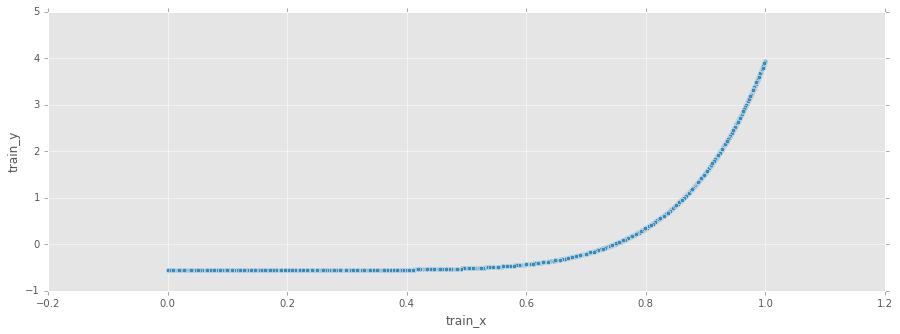

In [7]:
df.plot.scatter(x='train_x', y='train_y', figsize=(15,5));

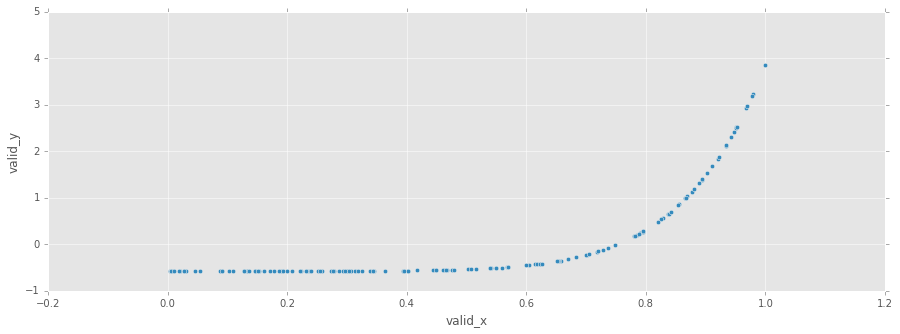

In [8]:
df_valid.plot.scatter(x='valid_x', y='valid_y', figsize=(15,5));

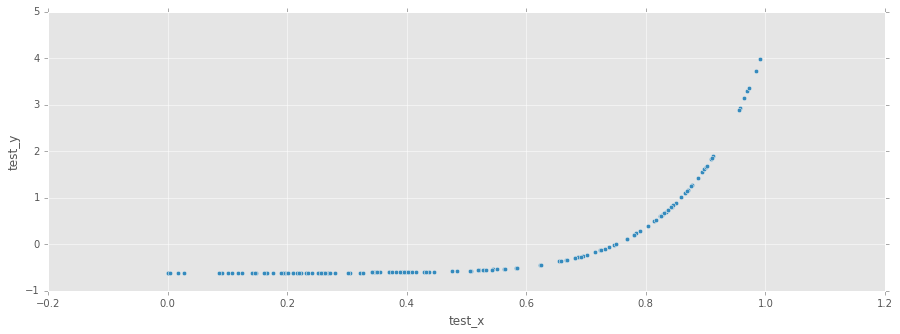

In [9]:
df_test.plot.scatter(x='test_x', y='test_y', figsize=(15,5));

# Helper Functions  

Make a function that will help you create layers easily

In [10]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases

    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

# Model your Graph

Start to use W (for weight) and b (for bias) when setting up your variables. Aside from adding your ReLU activation function, it is a good idea to use Tensorflow's ***matrix multiplication function (matmul)*** as shown below.  

> The ? in the shape output just means it can be of any shape.

# Pick Your Batch Size

In [11]:
# larger batch sizes help you get to the local minimum faster at a cost of more cpu power
# The strategy is to use batch_size when you cannot fit the entire dataset into memory
# In practice, small to moderate mini-batches (10-500) are generally used
batch_size = 100

# you can adjust the number of neurons in the hidden layers here
hidden_size = 10

# placeholders
# shape=[how many samples do you have, how many input neurons]
x = tf.placeholder(tf.float32, shape=[None, 1], name="01_x")
y = tf.placeholder(tf.float32, shape=[None, 1], name="01_y")

print("shape of x and y:")
print(x.get_shape(),y.get_shape())

# Add Your Drop Out Placeholder  

We will be feeding in the percentage of neurons to keep on every epoch

In [13]:
# drop out
keep_prob = tf.placeholder(tf.float32)

Note that the input of one layer becomes the input of the next layer.

In [14]:
# create your hidden layers!
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)

# here is where we shoot down some of the neurons
h1_drop = tf.nn.dropout(h1, keep_prob)

# add a second layer
h2 = add_layer(h1_drop, hidden_size, hidden_size, tf.nn.relu)
h2_drop = tf.nn.dropout(h2, keep_prob)

# add a third layer
h3 = add_layer(h2_drop, hidden_size, hidden_size, tf.nn.relu)
h3_drop = tf.nn.dropout(h3, keep_prob)

# add a fourth layer
h4 = add_layer(h3_drop, hidden_size, hidden_size, tf.nn.relu)
h4_drop = tf.nn.dropout(h4, keep_prob)

print("shape of hidden layers:")
print(h1_drop.get_shape(), h2_drop.get_shape(), h3_drop.get_shape(), h4_drop.get_shape())

shape of hidden layers:
(?, 10) (?, 10) (?, 10) (?, 10)


In [15]:
# Output Layers
pred = add_layer(h4_drop, hidden_size, 1)

print("shape of output layer:")
print(pred.get_shape())

shape of output layer:
(?, 1)


In [16]:
# minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(pred - y))

# pick optimizer
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss)

# Saving and Restoring Model

In [17]:
# Create variable to save and restore all of your variables
saver = tf.train.Saver()

# path
save_path = r"C:/Users/david/notebooks/tensorflow/tmp/model_" + datetime.datetime.now().strftime('%Y-%m-%d')

# How Good is Your model?  

Set up the following variables to calculate the accuracy rate of your model. You will do that shortly.

In [18]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Set Up Your Early Stoppage Variables  

Code borrowed from this great [Tensorflow Jupyter Notebook](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/04_Save_Restore.ipynb).

In [19]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 15000

# Training Time!  

The code below aims to save the best model you have seen during training. If an improvement is found, you save that model to disk. Also note that you can restore any saved model before you begin training so you can continue training a previosly saved model. Just make sure you have a saved model before running the restore code below. Note that saving your model constantly may ***slow down*** your training time.

> Where is my model getting saved?  

It should be inside the ***tmp*** folder.

In [20]:
# initialize the variables
init = tf.global_variables_initializer()

# hold step and error values
t = []

# Run your graph
with tf.Session() as sess:
    
    # restore model (no need to initialize variables if restorint model)
    saver.restore(sess, save_path=save_path)    
    
    # initialize variables
    sess.run(init)

    # Fit the function.
    for step in range(60000):
        
        # pull batches at random
        i = np.random.permutation(train_x.shape[0])[:batch_size]

        # get your data
        train_data = {x:train_x[i,:], y:train_y[i,:], keep_prob: 0.98}
        valid_data = {x:valid_x, y:valid_y, keep_prob: 1.0}
        test_data = {x:test_x, y:test_y, keep_prob: 1.0}
        
        # training in progress...
        train_loss, train_pred = sess.run([loss, train], feed_dict=train_data)        
        
        # print every n iterations
        if step%1000==0:
           
            # capture the step and error for analysis
            valid_loss = sess.run(loss, feed_dict=valid_data) 
            t.append((step, train_loss, valid_loss))    
            
            # get snapshot of current training and validation accuracy       
            train_acc = accuracy.eval(train_data)
            valid_acc = accuracy.eval(valid_data)           

            # If validation accuracy is an improvement over best-known.
            if valid_acc > best_valid_acc:
                # Update the best-known validation accuracy.
                best_valid_acc = valid_acc
                
                # Set the iteration for the last improvement to current.
                last_improvement = step
                
                # Save model to disk
                saver.save(sess, save_path=save_path)                

                # Flag when ever an improvement is found
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''   
                
            print("Training loss at step %d: %f %s" % (step, train_loss, improved_str))        
            print("Validation %f" % (valid_loss))            
                
            # If no improvement found in the required number of iterations.
            if step - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")

                # Break out from the for-loop.
                break                
            
            
    # here is where you see how good of a Data Scientist you are        
    print("Accuracy on the Training Set:", accuracy.eval(train_data) )
    print("Accuracy on the Validation Set:", accuracy.eval(valid_data) ) 
    print("Accuracy on the Test Set:", accuracy.eval(test_data) )
    
    # capture predictions on test data 
    test_results = sess.run(pred, feed_dict={x:test_x, keep_prob: 1.0})  
    df_final = pd.DataFrame({'test_x':test_x[:,0],
                             'pred':test_results[:,0]})
    
    # capture training and validation loss
    df_loss = pd.DataFrame(t, columns=['step', 'train_loss', 'valid_loss'])

Training loss at step 0: 1.147479 *
Validation 1.388356
Training loss at step 1000: 1.027446 *
Validation 0.995131
Training loss at step 2000: 0.988181 
Validation 0.986231
Training loss at step 3000: 1.258126 
Validation 0.971168
Training loss at step 4000: 0.655966 
Validation 0.941765
Training loss at step 5000: 0.805845 
Validation 0.874819
Training loss at step 6000: 0.430810 
Validation 0.708996
Training loss at step 7000: 0.569400 *
Validation 0.432954
Training loss at step 8000: 0.253947 *
Validation 0.230539
Training loss at step 9000: 0.142885 *
Validation 0.118798
Training loss at step 10000: 0.123665 
Validation 0.067341
Training loss at step 11000: 0.055928 
Validation 0.042721
Training loss at step 12000: 0.081819 
Validation 0.031563
Training loss at step 13000: 0.049281 
Validation 0.023350
Training loss at step 14000: 0.060906 
Validation 0.018348
Training loss at step 15000: 0.053416 
Validation 0.015116
Training loss at step 16000: 0.017379 *
Validation 0.010970
Trai

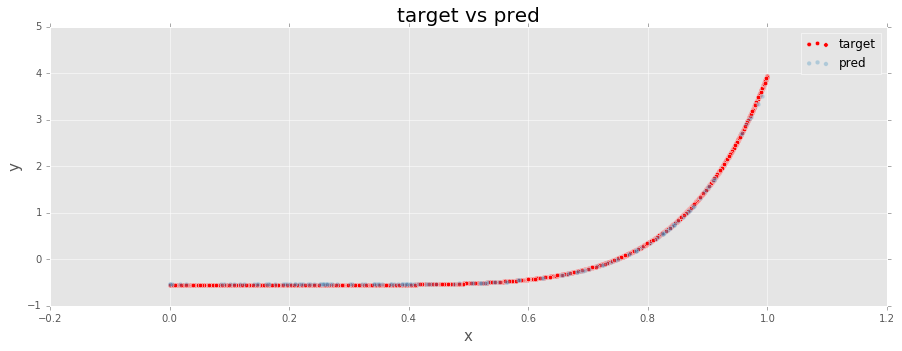

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# Chart 1 - Shows the line we are trying to model
df.plot.scatter(x='train_x', y='train_y', ax=axes, color='red')

# Chart 2 - Shows the line our trained model came up with
df_final.plot.scatter(x='test_x', y='pred', ax=axes, alpha=0.3)

# add a little sugar
axes.set_title('target vs pred', fontsize=20)
axes.set_ylabel('y', fontsize=15)
axes.set_xlabel('x', fontsize=15)
axes.legend(["target", "pred"], loc='best');

# Check for Overfitting  

If the ***valid_loss*** is increasing and your ***train_loss*** is decreasing then you have a problem. Since you have implemented early stopping, your model will not over train and prevents this issue from getting out of control.

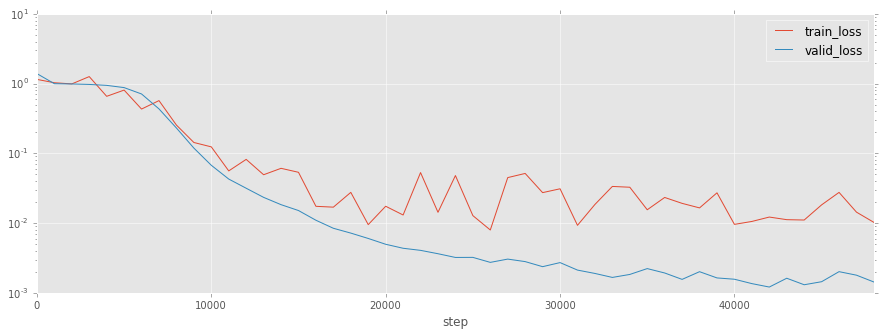

In [22]:
df_loss.set_index('step').plot(logy=True, figsize=(15,5));

# How Many Iterations Did I Go Through?  

I'll be honest with you. This function was giving me a lot of trouble. It is probably something I am doing wrong but it took me a while to get to a ***90% accuracy*** on the test set. I changed the size of each layer, the batch size, the learning rate, and even the initial sample size with no success. 

What finally worked was making sure I was saving the ***best*** model to disk and just simply re-running another 60,000 epochs on that model. I believe I completed ~6 runs of 60,000 training iterations. The chart above also started to become smoother and the accuracy started to climb. 

# Your Turn  

> Think about how you plan on saving your models. This tutorial saved the model by a date but that may not work for you. You might also consider writing a function that will pass in the name of your model. You may also consider saving a text file with all of the parameters you used during training. 

Try to come up with a much better model than mines. Try to beat 90% accuracy on the test set and with fewer training iterations. When you do, please share.

<p class="text-muted">This tutorial was created by <a href="http://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>